### Unet for steel defect image segementation part 2 (Testing and predictions)


### IDML 2 project submission by Fahad Deshmukh

In [3]:
import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.torch import ToTensor
import torch.utils.data as data
from model import Unet

### loading the test sets

In [4]:
import os
import pandas as pd
import shutil
import random

# Define the path to the current images directory
current_images_directory = "/kaggle/input/severstal-steel-defect-detection/train_images"  # Replace "path_to_current_images_directory" with the actual path

# Load the train.csv file
train_df = pd.read_csv('/kaggle/input/steelsudo1/sudo.csv', engine='python')  # Adjust the file path as per your directory structure

# Filter out rows where encoded pixels are not NaN
train_df_filtered = train_df.dropna(subset=['EncodedPixels'])

# Randomly select 100 images
random.seed(75)  # Set a seed for reproducibility
selected_rows = random.sample(range(len(train_df_filtered)), 1000)
selected_images_df = train_df_filtered.iloc[selected_rows]

# Create a new DataFrame with selected image IDs, class IDs, and encoded pixels
selected_images_new_df = selected_images_df[['ImageId_ClassId', 'EncodedPixels']].copy()

# Create a new directory to store selected images
output_directory = 'selected_images'
os.makedirs(output_directory, exist_ok=True)

# Copy selected images to the new directory
for index, row in selected_images_df.iterrows():
    image_filename = row['ImageId_ClassId'].split('_')[0]  # Assuming image filenames are based on image IDs
    image_source_path = os.path.join(current_images_directory, image_filename)
    image_dest_path = os.path.join(output_directory, image_filename)
    shutil.copy(image_source_path, image_dest_path)

# Save the DataFrame with selected images and encoded pixels to a new CSV file
selected_images_new_df.to_csv('selected_images_annotations.csv', index=False)


In [35]:
import os
import pandas as pd
import shutil

# Define the path to the current images directory
current_images_directory = "/kaggle/input/severstal-steel-defect-detection/train_images"  # Adjust this path as needed

# Load the train.csv file
train_df = pd.read_csv('/kaggle/input/steelsudo1/sudo.csv', engine='python')  # Adjust the file path as per your directory structure

# Select the first 2000 rows without filtering out nulls
first_2000_rows = train_df.head(2000)

# Extract unique image names from these rows
unique_images = first_2000_rows['ImageId_ClassId'].apply(lambda x: x.split('_')[0]).unique()

# Create a new DataFrame to store annotations for only the unique images
selected_images_new_df = first_2000_rows[first_2000_rows['ImageId_ClassId'].apply(lambda x: x.split('_')[0]).isin(unique_images)]

# Ensure the DataFrame has the columns 'ImageId_ClassId' and 'EncodedPixels'
selected_images_new_df = selected_images_new_df[['ImageId_ClassId', 'EncodedPixels']].copy()

# Create a new directory to store selected images
output_directory = 'selected_images2'
os.makedirs(output_directory, exist_ok=True)

# Copy unique images to the new directory
for image_filename in unique_images:
    image_source_path = os.path.join(current_images_directory, image_filename)
    image_dest_path = os.path.join(output_directory, image_filename)
    if os.path.exists(image_source_path):  # Check if the source image exists before copying
        shutil.copy(image_source_path, image_dest_path)

# Save the DataFrame with selected images and encoded pixels to a new CSV file
selected_images_new_df.to_csv('selected_images_annotations2.csv', index=False)


In [36]:
selected_images_new_df.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [5]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
## Test loader

In [6]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [7]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [8]:
!ls ../input/unetstartermodelfile/

model.pth


In [52]:
sample_submission_path = '/kaggle/working/selected_images_annotations2.csv'
test_data_folder = "/kaggle/working/selected_images2"

In [53]:
# initialize test dataloader
best_threshold = 0.5
num_workers = 2
batch_size = 4
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

best_threshold 0.5


In [54]:
# Initialize mode and load trained weights
ckpt_path = "/kaggle/input/trainedunetmodel/model.pth"
device = torch.device("cuda")
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Generating predictions dataframe

In [55]:
# start prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])



100%|██████████| 125/125 [00:12<00:00, 11.75it/s]


In [56]:
# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
#df['EncodedPixels'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
#df = df.dropna(subset=['EncodedPixels']).copy()

# Reset the index of the new DataFrame
#df.reset_index(drop=True, inplace=True)
df.to_csv("predictions2.csv", index=False)

In [20]:
df.to_csv("predictions.csv", index=False)

In [17]:
df.head()

ImageId_ClassId                                      EncodedPixels
0  82c806ebb.jpg_3  161325 13 161561 7 161573 24 161802 53 162056 ...
1  87754d760.jpg_3  357895 42 358149 69 358404 90 358660 115 35891...
2  87754d760.jpg_4  73062 5 73318 5 73573 6 73829 7 74083 9 74339 ...
3  e21fd95ad.jpg_4  18671 12 18922 19 19175 22 19431 22 19679 30 1...
4  c6a29f8f0.jpg_3  176519 7 176714 85 176812 8 176910 197 177124 ...

In [19]:
new_df = df.copy()


In [38]:
test_dataset = pd.read_csv('/kaggle/working/selected_images_annotations.csv')

In [39]:
test_dataset.head()

ImageId_ClassId                                      EncodedPixels
0  867572f1e.jpg_3  193533 4 193786 7 194041 8 194297 8 194552 9 1...
1  adf93f9bf.jpg_3  294386 15 294614 43 294842 71 295069 100 29529...
2  82c806ebb.jpg_3  158183 26 158388 77 158593 128 158798 179 1590...
3  87754d760.jpg_3  357378 10 357634 30 357890 49 358146 69 358402...
4  0c59df320.jpg_1  226142 6 226217 88 226392 20 226441 120 226643...

In [21]:
new_df.head()

ImageId_ClassId                                      EncodedPixels
0  82c806ebb.jpg_3  161325 13 161561 7 161573 24 161802 53 162056 ...
1  87754d760.jpg_3  357895 42 358149 69 358404 90 358660 115 35891...
2  87754d760.jpg_4  73062 5 73318 5 73573 6 73829 7 74083 9 74339 ...
3  e21fd95ad.jpg_4  18671 12 18922 19 19175 22 19431 22 19679 30 1...
4  c6a29f8f0.jpg_3  176519 7 176714 85 176812 8 176910 197 177124 ...

In [22]:
import numpy as np
import pandas as pd

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def decode_rle(encoded_pixels, height, width):
    '''
    Decode RLE encoded pixels to binary mask
    '''
    mask = np.zeros(height*width, dtype=np.uint8)
    encoded_pixels = encoded_pixels.split()
    for i in range(0, len(encoded_pixels), 2):
        start = int(encoded_pixels[i]) - 1
        length = int(encoded_pixels[i+1])
        mask[start:start+length] = 1
    return mask.reshape((height, width))

def calculate_dice(pred_mask, true_mask):
    '''
    Calculate Dice score for two binary masks
    '''
    intersection = np.sum(pred_mask * true_mask)
    dice = (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice

def calculate_iou(pred_mask, true_mask):
    '''
    Calculate IoU for two binary masks
    '''
    intersection = np.sum(pred_mask * true_mask)
    union = np.sum(pred_mask) + np.sum(true_mask) - intersection
    iou = intersection / union
    return iou

# Load test dataset and predicted DataFrame
test_dataset = pd.read_csv('/kaggle/working/selected_images_annotations.csv')  # Replace 'test_annotations.csv' with your test dataset file path
predicted_df = new_df.copy()  # Replace 'predicted_results.csv' with your predicted DataFrame

# Merge predictions with test dataset based on image IDs
merged_df = pd.merge(test_dataset, predicted_df, on='ImageId_ClassId')


In [23]:
merged_df.head()

ImageId_ClassId                                    EncodedPixels_x  \
0  82c806ebb.jpg_3  158183 26 158388 77 158593 128 158798 179 1590...   
1  87754d760.jpg_3  357378 10 357634 30 357890 49 358146 69 358402...   
2  e21fd95ad.jpg_4  17918 3 18169 8 18421 12 18674 15 18928 17 191...   
3  c6a29f8f0.jpg_3  175577 16 175831 20 176085 29 176339 40 176559...   
4  c85960383.jpg_3  16346 3 16601 8 16856 13 17111 18 17366 21 176...   

                                     EncodedPixels_y  
0  161325 13 161561 7 161573 24 161802 53 162056 ...  
1  357895 42 358149 69 358404 90 358660 115 35891...  
2  18671 12 18922 19 19175 22 19431 22 19679 30 1...  
3  176519 7 176714 85 176812 8 176910 197 177124 ...  
4  357966 18 358217 25 358470 29 358724 32 358978...

In [24]:
# Assuming 'merged_df' is your DataFrame
null_counts = merged_df.isnull().sum()

# Print the null counts for each column
print(null_counts)


ImageId_ClassId    0
EncodedPixels_x    0
EncodedPixels_y    0
dtype: int64


# Claculating Dice and IoU on test

In [25]:

# Calculate Dice score and IoU for each image
dice_scores = []
iou_scores = []
for index, row in merged_df.iterrows():
    pred_encoded_pixels = row['EncodedPixels_y']
    true_encoded_pixels = row['EncodedPixels_x']  # Assuming 'EncodedPixels' is the column containing true annotations
    height, width = 256, 1600  # Update with specific height and width

    # Decode predicted and true masks
    pred_mask = decode_rle(pred_encoded_pixels, height, width)
    true_mask = decode_rle(true_encoded_pixels, height, width)

    # Calculate Dice score and IoU
    dice = calculate_dice(pred_mask, true_mask)
    iou = calculate_iou(pred_mask, true_mask)

    dice_scores.append(dice)
    iou_scores.append(iou)

# Compute mean Dice score and mean IoU
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

print("Mean Dice Score on Test set:", mean_dice)
print("Mean IoU on Test set:", mean_iou)


Mean Dice Score on Test set: 0.7218554329427039
Mean IoU on Test set: 0.5956063720751633


In [28]:
#test_path='/kaggle/input/severstal-steel-defect-detection/test_images/'
train_path="/kaggle/working/selected_images"
train_csv="/kaggle/working/selected_images_annotations.csv"

In [57]:
train_df=pd.read_csv("/kaggle/working/predictions2.csv")

## Potting actualand predicted masks

In [58]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [39]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 228
the number of images with defects: 272


In [40]:
train_path = Path("/kaggle/working/selected_images2")

In [41]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [60]:
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [61]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

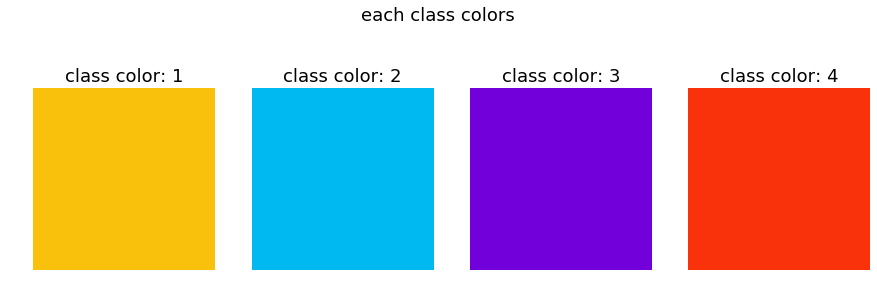

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [63]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

# Actual masks

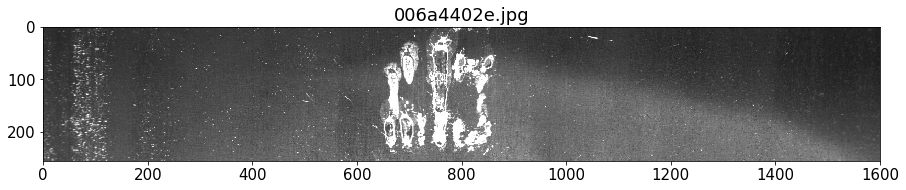

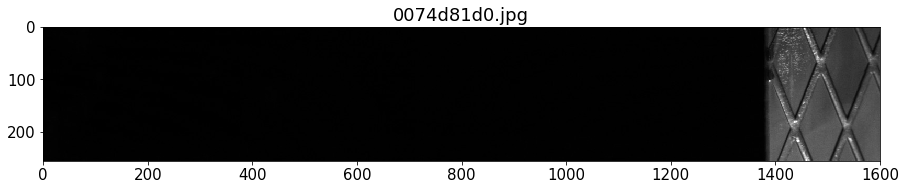

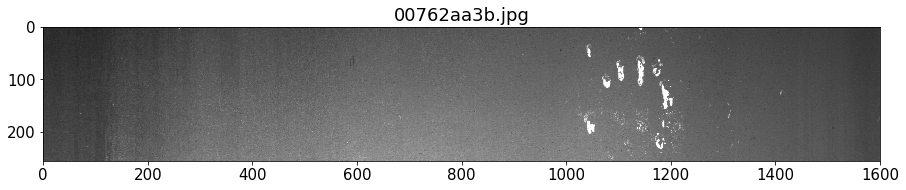

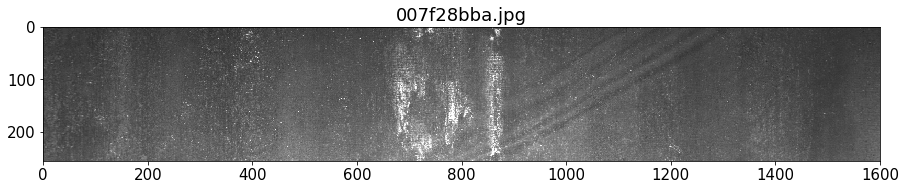

In [46]:
for idx in idx_no_defect[11:15]:
    show_mask_image(idx)

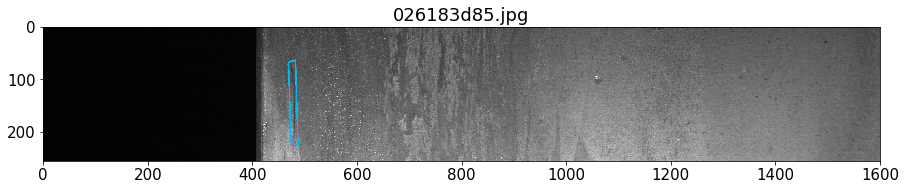

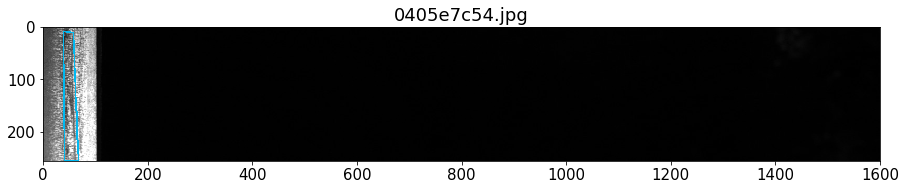

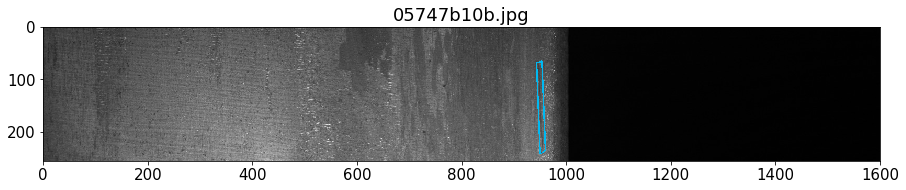

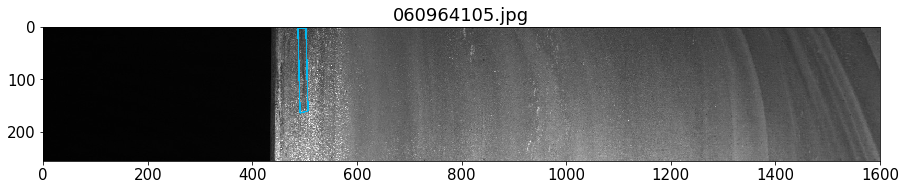

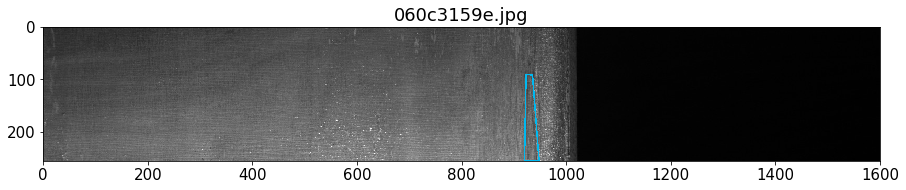

In [48]:
for idx in idx_class_2[:5]:
    show_mask_image(idx)

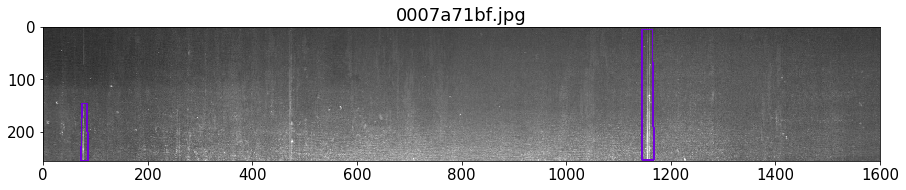

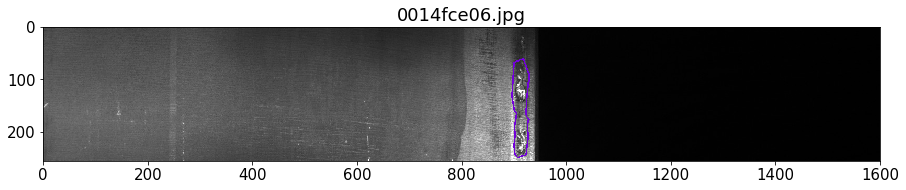

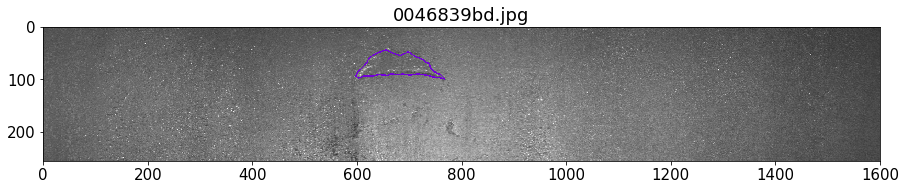

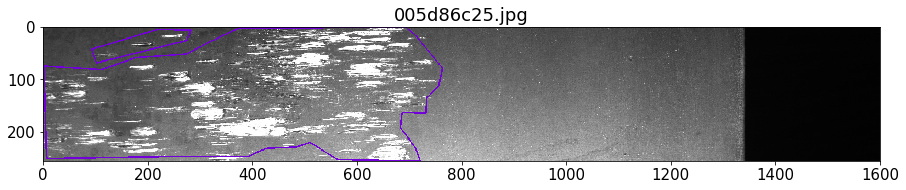

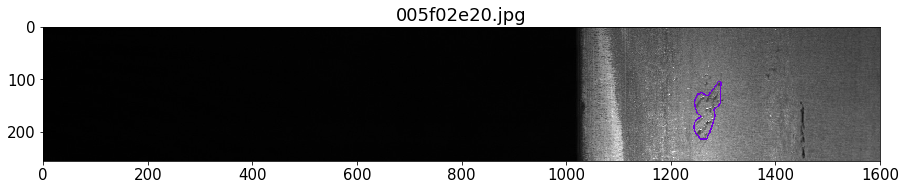

In [49]:
for idx in idx_class_3[:5]:
    show_mask_image(idx)

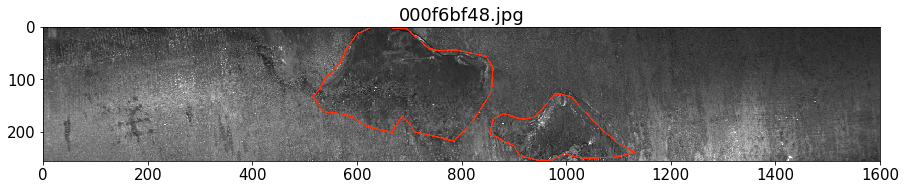

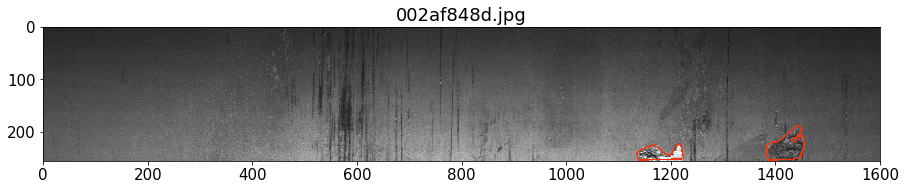

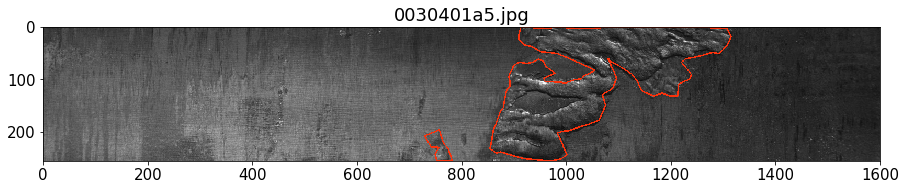

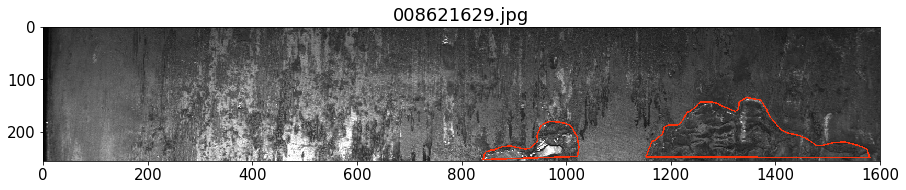

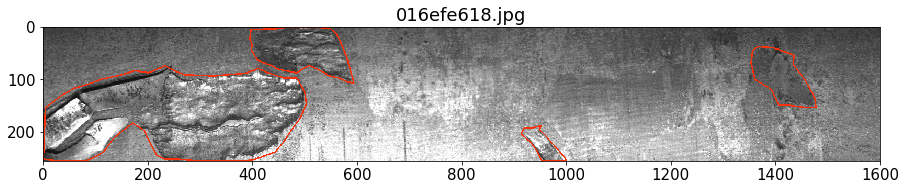

In [50]:
for idx in idx_class_4[:5]:
    show_mask_image(idx)

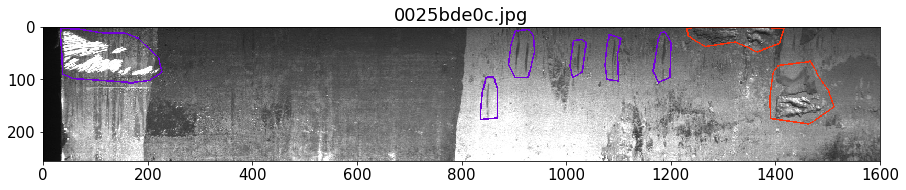

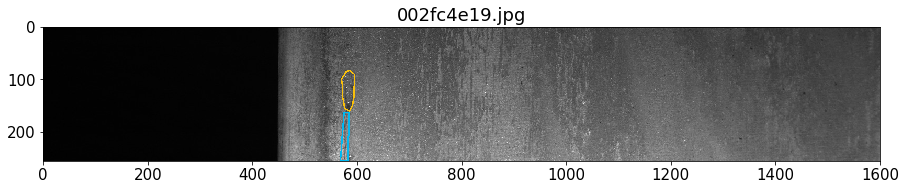

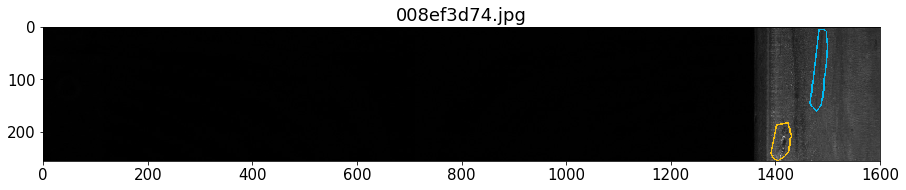

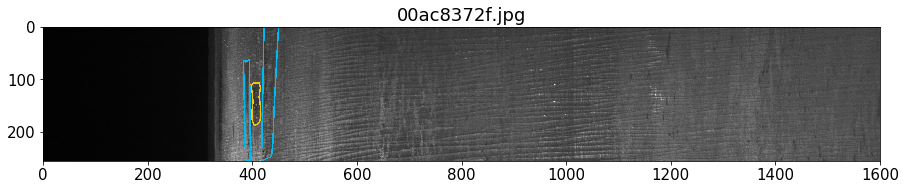

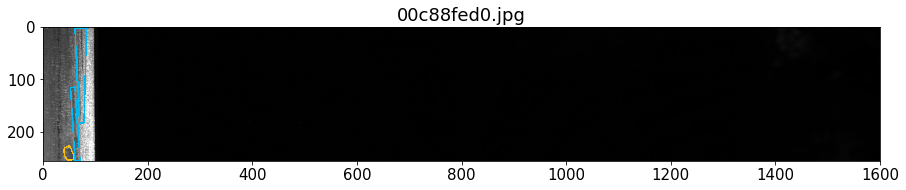

In [51]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

## Prediction masks

In [59]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 320
the number of images with defects: 180


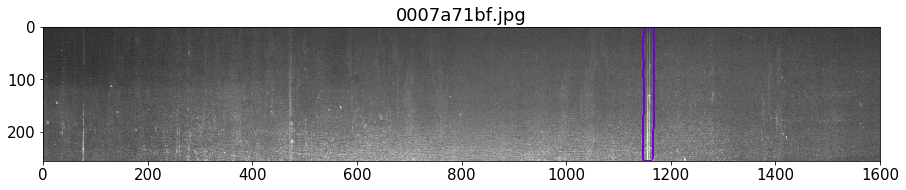

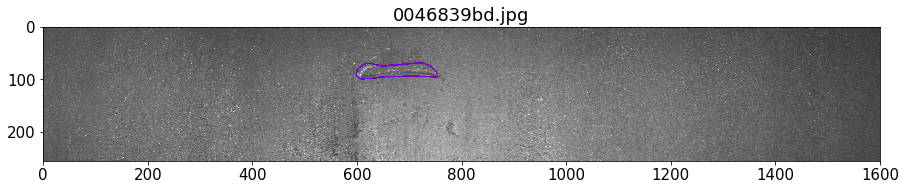

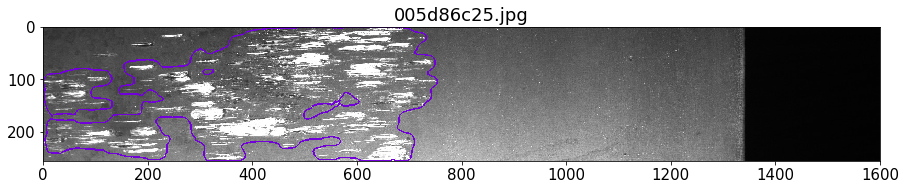

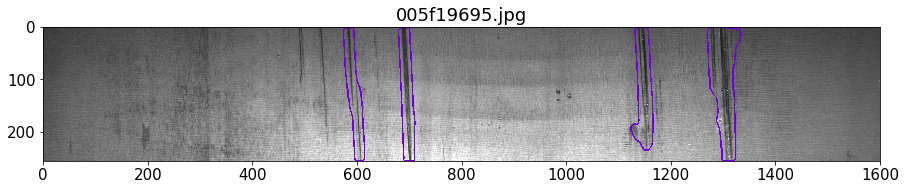

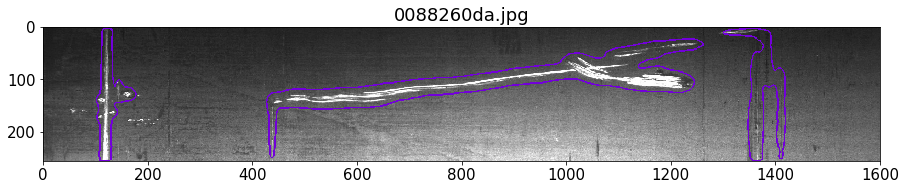

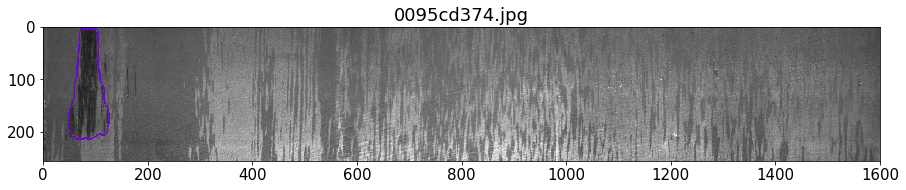

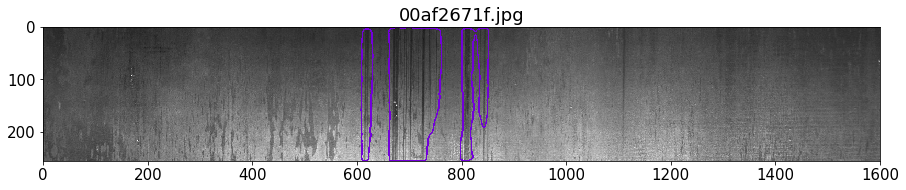

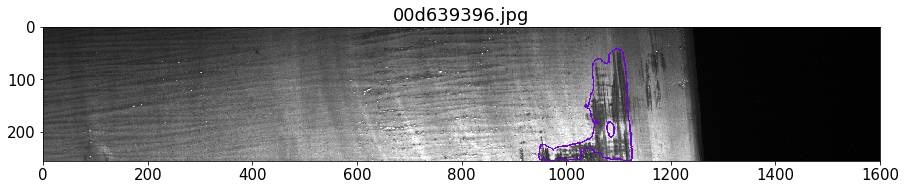

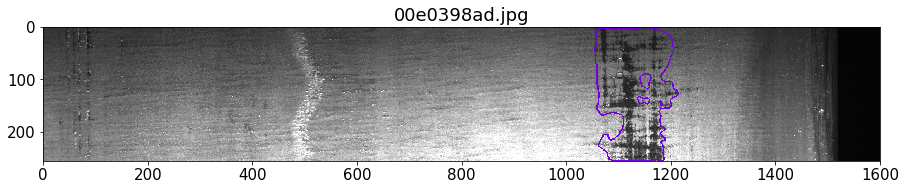

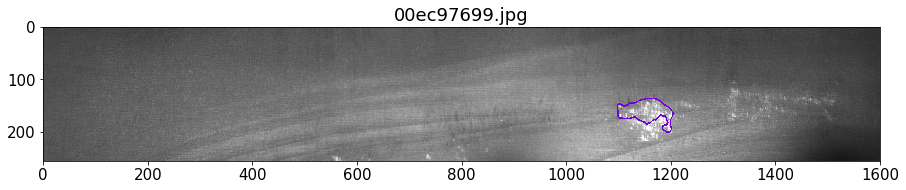

In [68]:
for idx in idx_class_3[:10]:
    show_mask_image(idx)

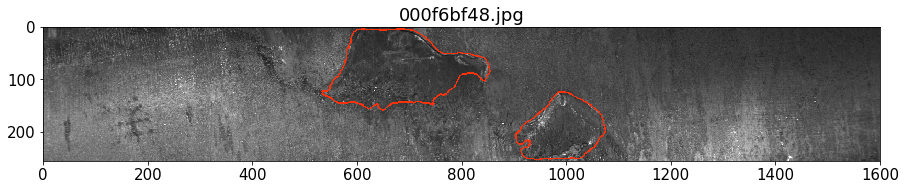

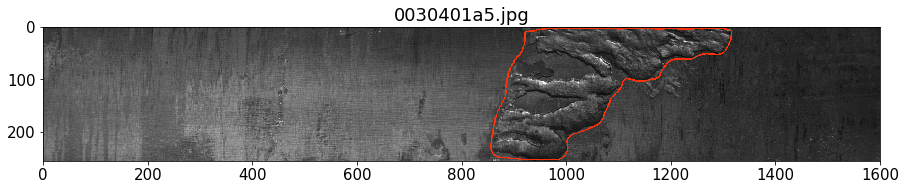

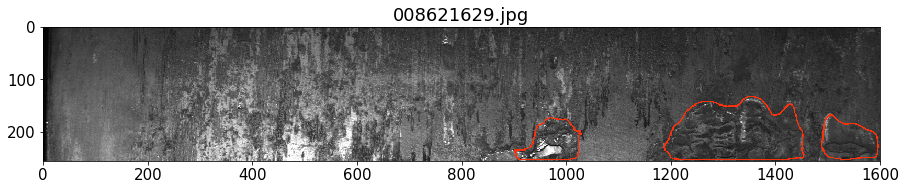

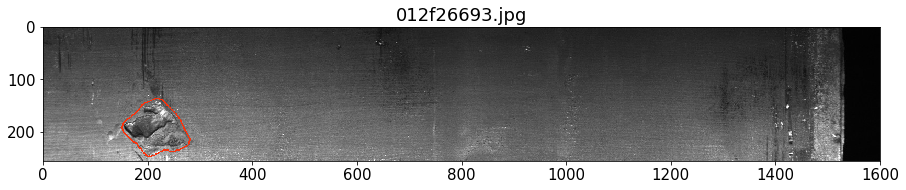

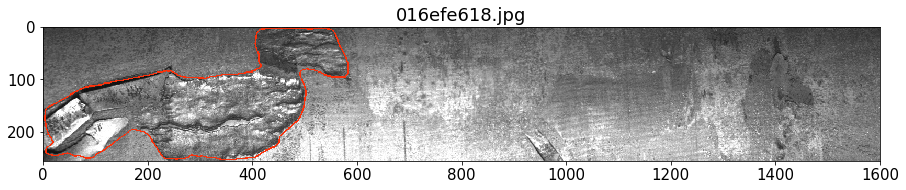

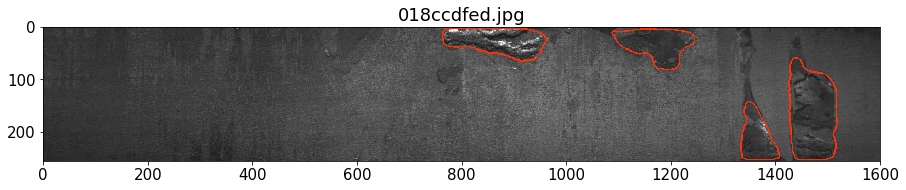

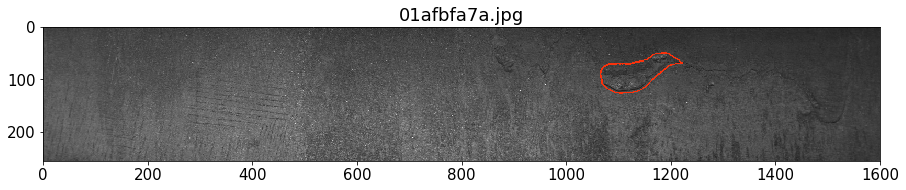

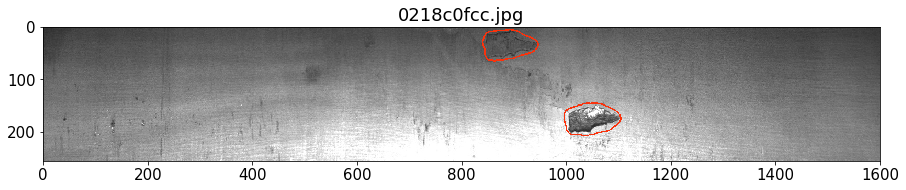

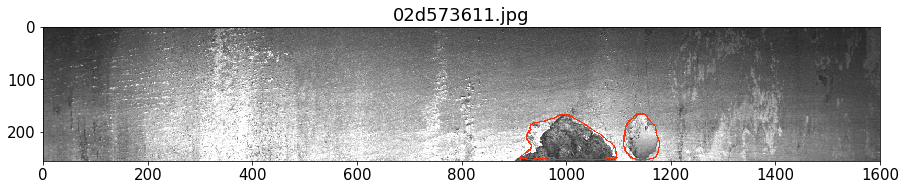

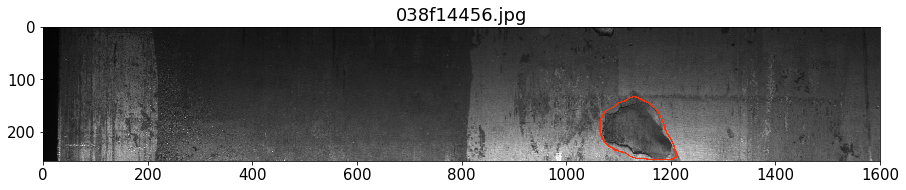

In [69]:
for idx in idx_class_4[:10]:
    show_mask_image(idx)

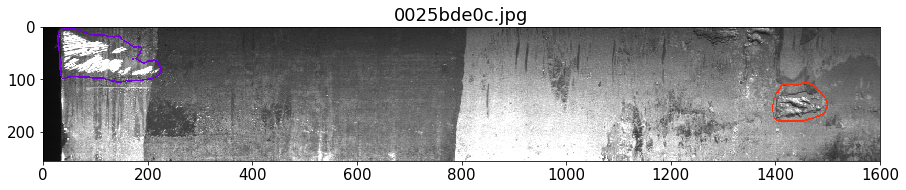

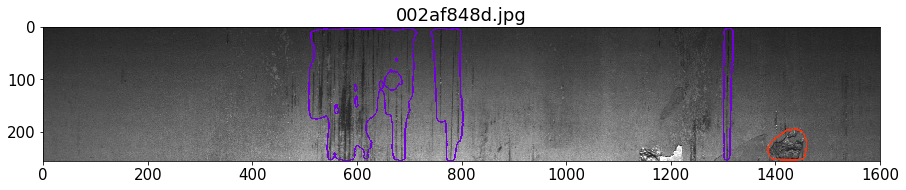

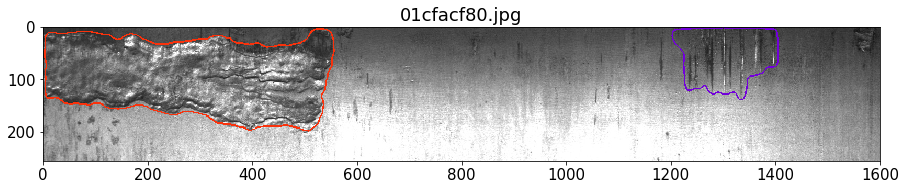

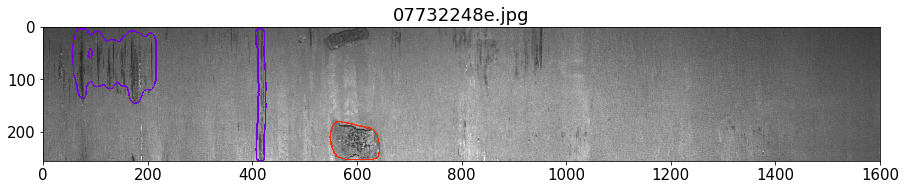

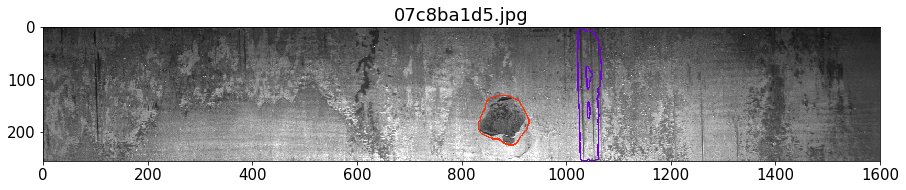

In [70]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

## Summary:

The goal of this project was to train a U-Net model for steel defect image segmentation. Two variations of the U-Net architecture were implemented:

1. **Baseline U-Net**: This model used a simple CNN as the encoder.
2. **Complex U-Net**: This model utilized ResNet18 with pre-trained weights as the encoder.

### Evaluation Metrics:
Both models were evaluated using Intersection over Union (IoU) and Dice score metrics.

### Performance Comparison:
The complex U-Net model with ResNet18 as the encoder outperformed the baseline U-Net model. It achieved a Dice score of around 0.7, indicating superior segmentation performance.

### Testing Phase:
The complex U-Net model was tested on unseen images. It produced satisfactory segmentation masks, demonstrating its ability to generalize well to new data.

Overall, the project successfully demonstrates the effectiveness of using a more complex architecture (U-Net with ResNet18) for steel defect image segmentation tasks. The model's performance was assessed using standard evaluation metrics and validated through testing on unseen images, showcasing its potential for practical applications in steel defect detection and segmentation.
